
# Heart Disease Prediction — End-to-End Model (ROC-AUC Focus)

This notebook builds a classification model to predict **heart disease** from patient health metrics using your uploaded dataset (`heart.csv`).  
It follows a clean ML workflow:

1. Load & inspect data  
2. Train/test split (with stratification)  
3. Preprocess numeric & categorical features  
4. Train several baseline models  
5. Evaluate using **ROC-AUC** (primary), plus accuracy & F1  
6. Plot ROC curves  
7. Save the **best model** & a short **markdown report**  
8. *(Optional)* Permutation feature importance for interpretability

> **Note:** This notebook uses only `matplotlib` for plotting and avoids seaborn.


In [11]:

# Install (if needed) and import libraries
import io
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    accuracy_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

import joblib

# Optional: permutation importance
try:
    from sklearn.inspection import permutation_importance
    HAS_PERM_IMPORTANCE = True
except Exception:
    HAS_PERM_IMPORTANCE = False

# Display library versions
print('pandas:', pd.__version__)
print('numpy:', np.__version__)


pandas: 2.3.1
numpy: 2.3.1



## 1. Load & Inspect Data
Update the `data_path` below if your file lives elsewhere.


In [13]:

data_path = Path('heart.csv')  # adjust if needed
df = pd.read_csv(data_path)

print('Shape:', df.shape)
print('\nPreview:')
display(df.head())

print('\nNull counts:')
print(df.isnull().sum())

# Capture info() text
buf = io.StringIO()
df.info(buf=buf)
print('\nDataFrame.info():')
print(buf.getvalue())


Shape: (303, 14)

Preview:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1



Null counts:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

DataFrame.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)


## 2. Define Target & Features
We try common target names (e.g., `target`, `output`, `outcome`). If none match, we default to the **last** column.


In [14]:

possible_targets = [c for c in df.columns if c.lower() in ['target','output','outcome','label','disease']]
target_col = possible_targets[0] if possible_targets else df.columns[-1]
print('Selected target column:', target_col)

X = df.drop(columns=[target_col])
y = df[target_col]

# Identify numeric vs categorical
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

print('Numeric columns:', num_cols)
print('Categorical columns:', cat_cols)


Selected target column: target
Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical columns: []



## 3. Train/Test Split (Stratified)
We hold out 20% for test evaluation.


In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()>1 else None
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (242, 13) Test shape: (61, 13)



## 4. Preprocessing Pipelines
- **Numeric:** median imputation + standard scaling  
- **Categorical:** most-frequent imputation + one-hot encoding


In [16]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
    ]
)



## 5. Train Baseline Models
We fit three solid baselines: **Logistic Regression**, **Random Forest**, **Gradient Boosting**.


In [17]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = []
trained = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)

    # Predict probabilities for ROC-AUC (if decision_function, rescale to [0,1])
    if hasattr(pipe.named_steps['model'], 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        scores = pipe.decision_function(X_test)
        smin, smax = scores.min(), scores.max()
        y_proba = (scores - smin) / (smax - smin + 1e-12)

    y_pred = pipe.predict(X_test)
    roc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='binary' if y.nunique()==2 else 'weighted')

    results.append({'model': name, 'roc_auc': roc, 'accuracy': acc, 'f1': f1})
    trained[name] = (pipe, y_proba, y_pred)

results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False).reset_index(drop=True)
results_df


,model,roc_auc,accuracy,f1
0,RandomForest,0.898810,0.819672,0.853333
1,GradientBoosting,0.879870,0.819672,0.845070
2,LogisticRegression,0.869048,0.803279,0.833333



## 6. ROC Curves


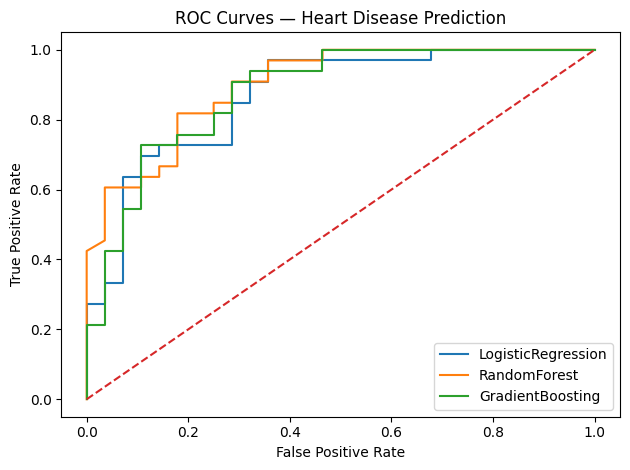

In [18]:

plt.figure()
for name, (pipe, y_proba, _) in trained.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Heart Disease Prediction')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



## 7. Best Model — Detailed Evaluation


In [19]:

best_row  = results_df.iloc[0]
best_name = best_row['model']
best_pipe, best_proba, best_pred = trained[best_name]

print('Best model:', best_name)
print('ROC-AUC:', round(best_row['roc_auc'], 4))
print('Accuracy:', round(best_row['accuracy'], 4))
print('F1:', round(best_row['f1'], 4))

cm = confusion_matrix(y_test, best_pred)
print('\nConfusion Matrix:')
print(cm)

print('\nClassification Report:')
print(classification_report(y_test, best_pred))


Best model: RandomForest
ROC-AUC: 0.8988
Accuracy: 0.8197
F1: 0.8533

Confusion Matrix:
[[18 10]
 [ 1 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61




## 8. Save Best Model & Markdown Report
This saves a pickle (`.pkl`) and a short report you can share.


In [43]:
from pathlib import Path
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Helper to format leaderboard
def df_to_md(df: pd.DataFrame) -> str:
    try:
        return df.to_markdown(index=False)
    except Exception:
        return df.to_string(index=False)

# Ensure best model exists
if "best_pipe" not in globals() or "best_name" not in globals():
    best_row = results_df.iloc[0]
    best_name = best_row["model"]
    best_pipe, best_proba, best_pred = trained[best_name]

# Metrics
cm = confusion_matrix(y_test, best_pred)
report_text = classification_report(y_test, best_pred)
best_row = results_df[results_df["model"] == best_name].iloc[0]

# Save paths
model_path = Path("/Users/jivalpatel/Downloads/Volunteer Work/Heart_DIsease_Prediction/best_heart_model.pkl")
report_path = Path("/Users/jivalpatel/Downloads/Volunteer Work/Heart_DIsease_Prediction/heart_model_report.md")
model_path.parent.mkdir(parents=True, exist_ok=True)

# Save model
joblib.dump(best_pipe, model_path)

# Build markdown report without f-string
md_report = "# Heart Disease Prediction Report\n\n"
md_report += "**Dataset:** " + getattr(data_path, 'name', str(data_path)) + "  \n"
md_report += "**Rows:** " + str(df.shape[0]) + " | **Columns:** " + str(df.shape[1]) + "  \n"
md_report += "**Target:** `" + str(target_col) + "`\n\n"

md_report += "## Model Leaderboard (by ROC-AUC)\n"
md_report += df_to_md(results_df)


## 9. Load Saved Model & Visualize Predictions

In this step, we will:

1. **Load** the saved `.pkl` model pipeline (which includes preprocessing and the trained best model).
2. **Run predictions** on the test set (`X_test`) if available, otherwise on the entire dataset.
3. **Display a preview table** showing:
   - Selected feature columns
   - Predicted probability of heart disease
   - Predicted label
   - (If available) True label
4. **Visualize performance**:
   - ROC Curve (if true labels are available)
   - Confusion Matrix (at a 0.5 probability threshold)
   - Histogram of predicted probabilities

These visuals help assess both the **discrimination** ability of the model (ROC curve) and **classification threshold behavior** (confusion matrix and probability distribution).


Preview of predictions (first 10 rows):


,age,sex,cp,trestbps,chol,pred_prob,pred_label,true_label
0,57,1,0,150,276,0.146,0,0
1,67,1,0,125,254,0.414,0,0
2,46,1,0,140,311,0.036,0,0
3,60,1,2,140,185,0.730,1,0
4,50,1,2,140,233,0.648,1,0
5,70,1,2,160,269,0.154,0,0
6,56,1,1,120,240,0.854,1,1
7,62,0,0,140,268,0.334,0,0
8,60,0,2,120,178,0.832,1,1
9,59,1,3,170,288,0.628,1,0


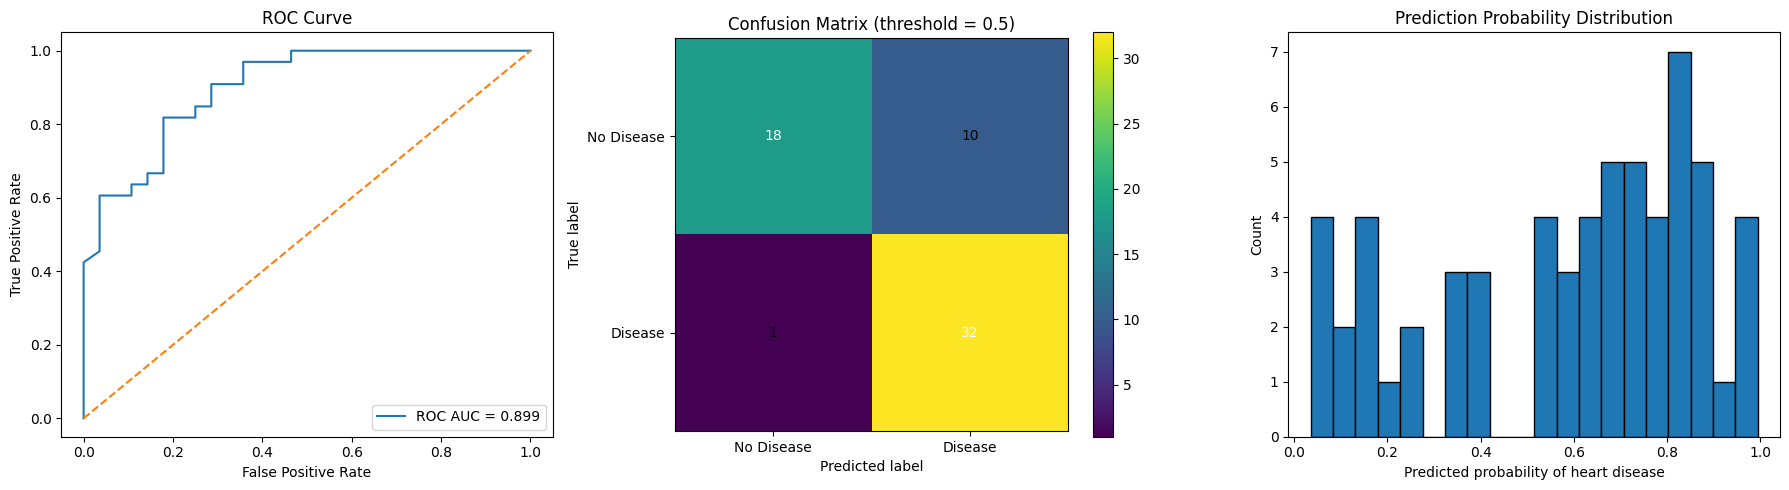

In [44]:
# === Use the saved model to visualize and predict ===

from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# --- Adjust this path if you saved the model elsewhere ---
model_path = Path("/Users/jivalpatel/Downloads/Volunteer Work/Heart_DIsease_Prediction/best_heart_model.pkl")

# Load trained pipeline (includes preprocessing + model)
pipe = joblib.load(model_path)

# Reconstruct features/labels if needed
# Assumes your original dataframe is `df` and (ideally) `target_col` is defined.
if "df" not in globals():
    # If your notebook kernel was reset, point this to your CSV:
    data_path = Path("/mnt/data/heart.csv")  # change if needed
    df = pd.read_csv(data_path)

if "target_col" not in globals() or target_col not in df.columns:
    # Fallback: assume the last column is the label
    target_col = df.columns[-1]

# Use test split if available; otherwise run on full data
use_test = "X_test" in globals() and "y_test" in globals()
if use_test:
    X_vis = X_test.copy()
    y_true = y_test.copy()
else:
    X_vis = df.drop(columns=[target_col]).copy()
    y_true = df[target_col].copy() if target_col in df.columns else None

# Predict probabilities and labels
if hasattr(pipe, "predict_proba"):
    y_proba = pipe.predict_proba(X_vis)[:, 1]
else:
    # Fallback for models without predict_proba
    scores = pipe.decision_function(X_vis)
    smin, smax = scores.min(), scores.max()
    y_proba = (scores - smin) / (smax - smin + 1e-12)

y_pred = (y_proba >= 0.5).astype(int)

# ---- Show a small table of predictions ----
preview_cols = list(X_vis.columns)[:5]  # show a few features for context
preds_df = pd.DataFrame({
    "pred_prob": y_proba,
    "pred_label": y_pred
}, index=X_vis.index)
if y_true is not None is not False:
    preds_df["true_label"] = y_true.values

preds_show = pd.concat([X_vis[preview_cols].reset_index(drop=True),
                        preds_df.reset_index(drop=True)], axis=1)
print("Preview of predictions (first 10 rows):")
display(preds_show.head(10))

# ---- Plots: ROC (if y available), Confusion Matrix (if y available), Prob. Histogram ----
num_plots = 1 + (1 if y_true is not None is not False else 0) + (1 if y_true is not None is not False else 0)
plt.figure(figsize=(6 * max(num_plots, 1), 5))

plot_idx = 1

# ROC Curve
if y_true is not None is not False:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    plt.subplot(1, num_plots, plot_idx)
    plt.plot(fpr, tpr, label="ROC AUC = {:.3f}".format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plot_idx += 1

# Confusion Matrix @ 0.5 threshold
if y_true is not None is not False:
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, num_plots, plot_idx)
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (threshold = 0.5)")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["No Disease", "Disease"])
    plt.yticks(tick_marks, ["No Disease", "Disease"])
    # Add text counts
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plot_idx += 1

# Histogram of predicted probabilities
plt.subplot(1, num_plots, plot_idx)
plt.hist(y_proba, bins=20, edgecolor="black")
plt.xlabel("Predicted probability of heart disease")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution")

plt.tight_layout()
plt.show()
